# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 1 – Kernel Screening

We build a Support Vector Machine (SVM) classifier using scikit-learn. A training dataset of 165 samples from healthy donors (DEV-165, source file: train_165_data_cleaned.csv) is used for kernel screening. Class labels are defined as 1 = good mRNA quality (T0) and 0 = poor mRNA quality, reflecting altered gene expression due to EDTA tube incubation.


Contents:
- **Data Preprocessing Before Loading**

- **Module Imports**

- **Importing and Preprocessing Training and Validation data**
    - Importing data
    - Splitting into dependent and independent variables
    - Splitting data into 80% (TRAIN-80) and 20% (VALID-20)
    - Scaling 
    - PCA transformation with 7 principal components (scree plot)
    - PCA transvormation with 2 principal components (PCA plot)

- ** Training part**
    - Generating fixed donor-group folds for cross-validation
    - Exploratory comparison of SVM kernel types
    - Hyperparameters selection for the polynomial kernel
    - Training final models on the full TRAIN-80 set
    - Visualization of decision boundaries for all models

- ** Validation part**
    - Threshold-free validation on the held-out 20% set (VALID-20)

----
----

#### **Data Preprocessing Before Loading**

- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: GAPDH, GUSB, and PPIB (sequences of optimized primers can be found at https://pubmed.ncbi.nlm.nih.gov/25369468/).
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 
- In Genex Enterprise (MultiD), SOM analysis identified clerly distinguished two classes in the training set.

----
----

#### **Module Import**

In [35]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [36]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data"
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"


# Create folders if needed
DATA_DIR.mkdir(parents=True, exist_ok=True)
NB_OUTPUT.mkdir(parents=True, exist_ok=True)

# Paths to data
DEV_DATA_PATH = DATA_DIR / "train_165_data_cleaned.csv"
SPLIT_8020_PATH = NB_OUTPUT / "dev165_split_80_20.csv" 
FOLDS_PATH = NB_OUTPUT / "train80_folds.csv"


print("ROOT:", ROOT)
print("DEV_DATA_PATH:", DEV_DATA_PATH, "Exists?", DEV_DATA_PATH.exists())
print("SPLIT_8020_PATH:", SPLIT_8020_PATH, "Exists?", SPLIT_8020_PATH.exists())


ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\train_165_data_cleaned.csv Exists? True
SPLIT_8020_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\dev165_split_80_20.csv Exists? True


In [37]:
# ── Visualization settings (colors, markers) ──
COLORS = {
    "train_0": "#fb9a99",
    "train_1": "#a6cee3",
    "val_0": "#e31a1c",
    "val_1": "#1f78b4"
}

MARKERS = {
    "train": "o",
    "val": "^"
}

POINT_SIZES = {
    "train": 80,
    "val": 100
}

#### Directory Structure Overview (optional)

This cell prints the folder and file structure of the current working directory using `os.walk()`.
It is useful for debugging or verifying that all necessary files are in place.  

In [38]:

for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.path.sep, "/").count("/")
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

./
    1_SVM_model_kernel_04122025_final .ipynb
    2_SVM_model_development_10122025_final.ipynb
    3_SVM_decision_boundary_11122025_final.ipynb
    3_SVM_decision_boundary_24112025 copy.ipynb
    4_sillhouette_score_moje.ipynb
    5_SVM_obrazky.ipynb
    Figure.png
    figure4.ipynb
    safe_threshold.json
    outputs_from_notebooks/
        220svm_test_predictions.xlsx
        220unknown_predictions_FNR0.csv
        220unknown_predictions_FNR1.csv
        220unknown_predictions_FNR10.csv
        220unknown_predictions_FNR2.csv
        220unknown_predictions_FNR3.csv
        220unknown_predictions_FNR4.csv
        220unknown_predictions_FNR5.csv
        220unknown_predictions_FNR6.csv
        220unknown_predictions_FNR7.csv
        220unknown_predictions_FNR8.csv
        220unknown_predictions_FNR9.csv
        dev165_folds.csv
        dev165_split_80_20.csv
        final_pipeline_prob.joblib
        svm_val_predictions.xlsx
        train80_folds.csv
        unknown_FNR_comparison.xls

In [39]:
print("ROOT:", ROOT)
print("DEV_DATA_PATH:", DEV_DATA_PATH)
print("Exists?", DEV_DATA_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\train_165_data_cleaned.csv
Exists? True


----
----

#### **Importing and Preprocessing Training and Validation data**

#### Task 1: Importing data

In [40]:
dev_165_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

In [41]:
dev_165_df.head()

,BTG3_dCq,CD69_dCq,CXCR1_dCq,CXCR2_dCq,FCGR3_dCq,JUN_dCq,STEAP4_dCq,donor_id,label
sample,,,,,,,,,
1 EDTA val T0,5.48,6.92,-1.51,-0.85,-3.65,3.15,-0.31,1,1
1 EDTA val T24,2.84,3.26,0.73,2.02,-1.45,-2.15,1.60,1,0
1 EDTA val T48,2.31,2.19,2.90,4.30,0.87,-3.57,4.00,1,0
10 EDTA val T0,4.51,5.49,-2.14,-0.91,-3.44,1.57,-0.83,10,1
10 EDTA val T24,3.06,2.23,0.50,1.79,-1.38,-2.34,1.32,10,0


In [42]:
print(dev_165_df.shape)
print(dev_165_df.columns.tolist())
print(dev_165_df.isna().sum())

(165, 9)
['BTG3_dCq', 'CD69_dCq', 'CXCR1_dCq', 'CXCR2_dCq', 'FCGR3_dCq', 'JUN_dCq', 'STEAP4_dCq', 'donor_id', 'label']
BTG3_dCq      0
CD69_dCq      0
CXCR1_dCq     0
CXCR2_dCq     0
FCGR3_dCq     0
JUN_dCq       0
STEAP4_dCq    0
donor_id      0
label         0
dtype: int64


- POOR: Group 0: samples with altered gene expression = poor samples
- PK: Group 1 samples at time 0 = good samples

----

#### Task 2: Splitting into dependent and independent variables

In [43]:
X = dev_165_df[["BTG3_dCq", "CD69_dCq", "CXCR1_dCq", "CXCR2_dCq", "FCGR3_dCq", "JUN_dCq", "STEAP4_dCq"]].values
y = dev_165_df["label"].values
groups = dev_165_df["donor_id"].values

----

#### Task 3: Splitting data into 80% (TRAIN-80) and 20% (VALID-20)

In [44]:
# If split metadata already exists, load it to keep the split stable.
# Otherwise create a new split.
if SPLIT_8020_PATH.exists():
    print("Loading existing 80/20 donor-disjoint split...")
    splits_8020 = pd.read_csv(SPLIT_8020_PATH)
else:
    print("Creating new 80/20 donor-disjoint split...")
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, cal_idx = next(sgkf.split(X, y, groups))

    splits_8020 = pd.DataFrame({
        "sample_id": dev_165_df.index.to_list(),
        "donor_id": groups,
        "label": y,
        "role": "train"
    })
    splits_8020.loc[cal_idx, "role"] = "cal"
    splits_8020.to_csv(SPLIT_8020_PATH, index=False)

splits_8020["role"].value_counts()


Loading existing 80/20 donor-disjoint split...


role
train    132
cal       33
Name: count, dtype: int64

In [45]:
train_mask = splits_8020["role"] == "train"
cal_mask   = splits_8020["role"] == "cal"

X_tr = X[train_mask.values]
y_tr = y[train_mask.values]
grp_tr = groups[train_mask.values]

X_cal = X[cal_mask.values]
y_cal = y[cal_mask.values]
grp_cal = groups[cal_mask.values]

print("TRAIN-80:", X_tr.shape, "VALID-20:", X_cal.shape)
print("Donors TRAIN:", len(np.unique(grp_tr)))
print("Donors VALID:", len(np.unique(grp_cal)))


TRAIN-80: (132, 7) VALID-20: (33, 7)
Donors TRAIN: 44
Donors VALID: 11


In [46]:
# ---- Print class distribution in TRAIN vs VALID ----

train_counts = pd.Series(y_tr).value_counts().rename({0: "POOR", 1: "GOOD"})
valid_counts = pd.Series(y_cal).value_counts().rename({0: "POOR", 1: "GOOD"})

print("Class distribution:")
print("TRAIN-80:")
print(train_counts)

print("\nVALID-20:")
print(valid_counts)

# Optional: percentages for a nicer overview
print("\nPercentages:")
print("TRAIN-80 (%)")
print((train_counts / len(y_tr) * 100).round(2))

print("\nVALID-20 (%)")
print((valid_counts / len(y_cal) * 100).round(2))


Class distribution:
TRAIN-80:
POOR    87
GOOD    45
Name: count, dtype: int64

VALID-20:
POOR    22
GOOD    11
Name: count, dtype: int64

Percentages:
TRAIN-80 (%)
POOR    65.91
GOOD    34.09
Name: count, dtype: float64

VALID-20 (%)
POOR    66.67
GOOD    33.33
Name: count, dtype: float64


----
----

#### Task 4: Scaling

In [47]:
# Initialization of StandardScaler
scaler = StandardScaler()

# Fit and transform training data only
X_tr_scaled = scaler.fit_transform(X_tr)

# Transform validation data using the fitted scaler
X_cal_scaled = scaler.transform(X_cal)

----

#### Task 5: PCA transformation with 7 principal components for Scree plot

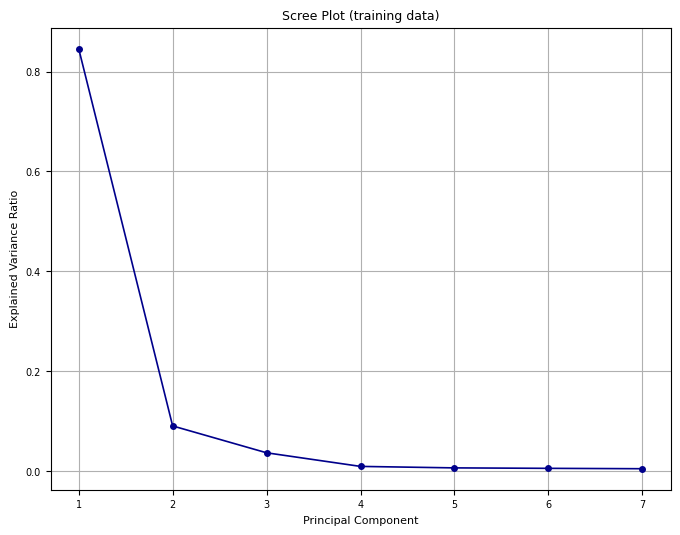

In [48]:
# Fit PCA on all components
pca_full = PCA().fit(X_tr_scaled) # n_components default = n_features (7)

X_tr_scaled_pca7  = pca_full.transform(X_tr_scaled) # NOT a final model only exploratory!
X_cal_scaled_pca7 = pca_full.transform(X_cal_scaled)

# Scree plot of explained variance ratio
plt.figure(figsize=(8,6))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1), 
    pca_full.explained_variance_ratio_, 
    'o-', color='darkblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (training data)')
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

A scree plot shows how much variation is captured by each principal component. In this dataset, PC1 explains the largest proportion of the variance, while PC2 contributes an additional, smaller fraction. Together, the first two components capture more than 80% of the total variance. This supports the use of a two-dimensional PCA projection for visualization.

----

#### Task 6: PCA transformation with 2 principal components for PCA plot

In [49]:
# PCA with 2PC
pca2 = PCA(n_components=2)
X_tr_scaled_pca2 = pca2.fit_transform(X_tr_scaled) # NOT a final model only visualization!
X_cal_scaled_pca2 = pca2.transform(X_cal_scaled)

print(
    f"✅ Training and validation sets have been scaled and PCA-transformed: "
    f"{X_tr_scaled_pca2.shape} train, {X_cal_scaled_pca2.shape} validation.")

# The PCA coordinates (2D) are shared across all visualizations (RBF, Polynomial).
# These are computed once and reused, since PCA is independent of the SVM kernel.

✅ Training and validation sets have been scaled and PCA-transformed: (132, 2) train, (33, 2) validation.


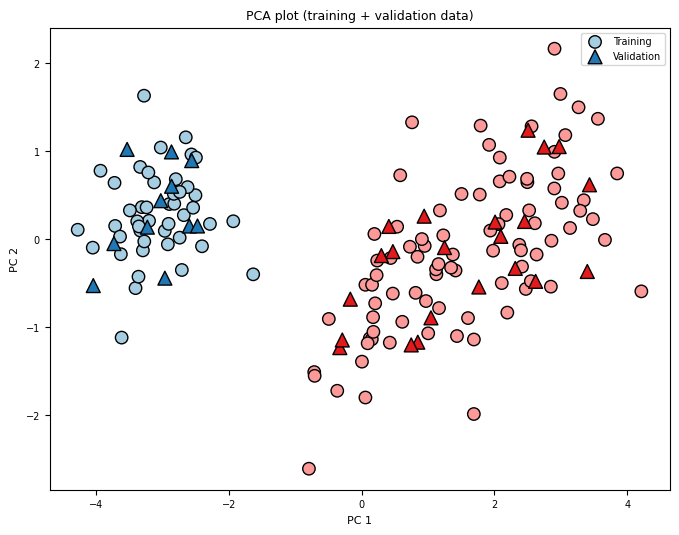

In [50]:
plt.figure(figsize=(8,6))

# Define color palettes
cmap_tr = ListedColormap([COLORS["train_0"], COLORS["train_1"]])
cmap_cal   = ListedColormap([COLORS["val_0"], COLORS["val_1"]])

# Training data
plt.scatter(
    X_tr_scaled_pca2[:, 0], X_tr_scaled_pca2[:, 1],
    c=y_tr, cmap=cmap_tr, edgecolors='k', s=POINT_SIZES["train"], label='Training'
)

# Validation data
plt.scatter(
    X_cal_scaled_pca2[:, 0], X_cal_scaled_pca2[:, 1],
    c=y_cal, cmap=cmap_cal, marker=MARKERS["val"], edgecolors='k', s=POINT_SIZES["val"], label='Validation'
)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA plot (training + validation data)')
plt.legend()
plt.show()


Red color = samples with altered gene expression. Blue color = good control samples at T0.

----
----

#### **Training part**

#### Task 7: Generating fixed donor-group folds for later cross-validation

In [54]:
# Create new CV fold split based ONLY on TRAIN-80
print("Creating new 5-fold donor-disjoint CV for TRAIN-80...")

sgkf_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

folds = list(sgkf_cv.split(X_tr, y_tr, grp_tr))

# Save folds for reproducibility
rows = []
for fold_id, (f_train, f_test) in enumerate(folds):
    for idx in f_train:
        rows.append({"fold": fold_id, "subset": "train", "index": int(idx)})
    for idx in f_test:
        rows.append({"fold": fold_id, "subset": "test", "index": int(idx)})

folds_df = pd.DataFrame(rows)
folds_df.to_csv(NB_OUTPUT / "train80_folds.csv", index=False)

print(f"CV folds saved to: {FOLDS_PATH}")



Creating new 5-fold donor-disjoint CV for TRAIN-80...
CV folds saved to: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\notebooks\outputs_from_notebooks\train80_folds.csv


In [55]:
folds_df = pd.read_csv(FOLDS_PATH)
folds_df.head()

,fold,subset,index
0,0,train,0
1,0,train,1
2,0,train,2
3,0,train,3
4,0,train,4


In [56]:


folds_loaded = []
for fold_id in sorted(folds_df["fold"].unique()):
    f_train = folds_df[(folds_df.fold == fold_id) & (folds_df.subset == "train")]["index"].values
    f_test  = folds_df[(folds_df.fold == fold_id) & (folds_df.subset == "test")]["index"].values
    folds_loaded.append((f_train, f_test))

print("CV folds loaded:", len(folds_loaded))


CV folds loaded: 5


In [57]:
for i, (f_train, f_test) in enumerate(folds_loaded):
    print(f"Fold {i}: train={len(f_train)}, test={len(f_test)}")
     # Donor leakage check
    assert len(np.intersect1d(grp_tr[f_train], grp_tr[f_test])) == 0, f"Donor leak in fold {i+1}"


Fold 0: train=105, test=27
Fold 1: train=105, test=27
Fold 2: train=105, test=27
Fold 3: train=106, test=26
Fold 4: train=107, test=25


In [58]:
print("Max index in folds:", max(folds_df["index"]))
print("TRAIN-80 size:", len(X_tr))


Max index in folds: 131
TRAIN-80 size: 132


----

#### Task 8: Exploratory comparison of SVM kernel types

In [59]:
# Kernels to evaluate
kernels = {
    "POLY": {"kernel": "poly", "degree": 2},
    "RBF":  {"kernel": "rbf"},
}

In [60]:
cv_results = []

for kernel_name, params in kernels.items():
    auc_scores = []
    sv_counts = []
    sv_fracs = []

    print(f"\n🔍 Evaluating kernel: {kernel_name}")
    
    for fold_id, (f_train, f_test) in enumerate(folds_loaded, start=1):
        
        Xtr, Xte = X_tr[f_train], X_tr[f_test]
        ytr, yte = y_tr[f_train], y_tr[f_test]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(**params))
        ])

        pipe.fit(Xtr, ytr)

        # AUC (threshold-free)
        scores = pipe.decision_function(Xte)
        fold_auc = roc_auc_score(yte, scores)
        auc_scores.append(fold_auc)

        # Support vector stats
        svm_step = pipe.named_steps["svm"]
        n_sv = len(svm_step.support_)
        sv_counts.append(n_sv)
        sv_fracs.append(n_sv / len(f_train))

        print(f"[Fold {fold_id}] AUC={fold_auc:.3f}, SV={n_sv}, SV_frac={sv_fracs[-1]:.2%}")

    cv_results.append({
        "kernel": kernel_name,
        "auc_mean": np.mean(auc_scores),
        "auc_sd": np.std(auc_scores),
        "sv_mean": np.mean(sv_counts),
        "sv_sd": np.std(sv_counts),
        "sv_frac_mean": np.mean(sv_fracs),
        "auc_scores": auc_scores,
        "sv_counts": sv_counts,
    })

    print(f"\n📊 Summary for {kernel_name}:")
    print(f"AUC mean ± SD: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"SV mean ± SD: {np.mean(sv_counts):.1f} ± {np.std(sv_counts):.1f}")
    print(f"SV fraction mean: {np.mean(sv_fracs):.2%}")




🔍 Evaluating kernel: POLY
[Fold 1] AUC=0.981, SV=46, SV_frac=43.81%
[Fold 2] AUC=0.914, SV=49, SV_frac=46.67%
[Fold 3] AUC=0.920, SV=48, SV_frac=45.71%
[Fold 4] AUC=0.967, SV=47, SV_frac=44.34%
[Fold 5] AUC=0.931, SV=45, SV_frac=42.06%

📊 Summary for POLY:
AUC mean ± SD: 0.943 ± 0.027
SV mean ± SD: 47.0 ± 1.4
SV fraction mean: 44.52%

🔍 Evaluating kernel: RBF
[Fold 1] AUC=1.000, SV=14, SV_frac=13.33%
[Fold 2] AUC=1.000, SV=14, SV_frac=13.33%
[Fold 3] AUC=1.000, SV=15, SV_frac=14.29%
[Fold 4] AUC=1.000, SV=14, SV_frac=13.21%
[Fold 5] AUC=1.000, SV=14, SV_frac=13.08%

📊 Summary for RBF:
AUC mean ± SD: 1.000 ± 0.000
SV mean ± SD: 14.2 ± 0.4
SV fraction mean: 13.45%


RBF performed well in baseline comparison, but polynomial SVM was tuned further due to its interpretable and stable quadratic margin.

----

#### Task 9: Hyperparameters selection for polynomial kernel

We next tune the hyperparameters of the polynomial SVM. The polynomial degree is fixed at 2 to limit model complexity in this dataset, while still allowing a nonlinear separation of the two classes.

In [61]:
# Hyperparameter tuning for polynomial SVM (degree = 2)
# We work only on TRAIN-80 and donor-disjoint folds (folds_loaded).

param_grid = {
    "C":     [0.1, 0.5, 1, 2, 5, 10],
    "gamma": ["scale", 1.0, 0.5, 0.2, 0.1, 0.05, 0.01],
    "coef0": [0.0, 0.5, 1.0, 2.0],
}


In [62]:
auc

<function sklearn.metrics._ranking.auc(x, y)>

In [63]:
best_auc = -1.0 # We initialize best_auc = -1 because AUC is always ≥ 0, so any real model will automatically perform better and replace this initial value.
best_params = None

print("🔍 Starting polynomial SVM tuning (degree = 2)...")

🔍 Starting polynomial SVM tuning (degree = 2)...


In [64]:
for C in param_grid["C"]:
    for gamma in param_grid["gamma"]:
        for coef0 in param_grid["coef0"]:

            fold_aucs = []

            # donor-disjoint CV using precomputed folds
            for fold_id, (f_train, f_test) in enumerate(folds_loaded, start=1):
                Xtr = X_tr[f_train]
                Xte = X_tr[f_test]
                ytr = y_tr[f_train]
                yte = y_tr[f_test]

                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svm", SVC(
                        kernel="poly",
                        degree=2,
                        C=C,
                        gamma=gamma,
                        coef0=coef0,
                        class_weight="balanced",
                        probability=False,
                        random_state=42,
                    )),
                ])

                pipe.fit(Xtr, ytr)
                scores = pipe.decision_function(Xte)
                auc_val = roc_auc_score(yte, scores)
                fold_aucs.append(auc_val)

            mean_auc = np.mean(fold_aucs)
            print(f"C={C}, gamma={gamma}, coef0={coef0} → AUC={mean_auc:.3f}")

            if mean_auc > best_auc:
                best_auc = mean_auc
                best_params = {"C": C, "gamma": gamma, "coef0": coef0}

print("\n✨ Best POLY hyperparameters (degree = 2):")
print(best_params)
print(f"Mean CV AUC: {best_auc:.3f}")


C=0.1, gamma=scale, coef0=0.0 → AUC=0.915
C=0.1, gamma=scale, coef0=0.5 → AUC=1.000
C=0.1, gamma=scale, coef0=1.0 → AUC=1.000
C=0.1, gamma=scale, coef0=2.0 → AUC=1.000
C=0.1, gamma=1.0, coef0=0.0 → AUC=0.945
C=0.1, gamma=1.0, coef0=0.5 → AUC=1.000
C=0.1, gamma=1.0, coef0=1.0 → AUC=1.000
C=0.1, gamma=1.0, coef0=2.0 → AUC=1.000
C=0.1, gamma=0.5, coef0=0.0 → AUC=0.939
C=0.1, gamma=0.5, coef0=0.5 → AUC=1.000
C=0.1, gamma=0.5, coef0=1.0 → AUC=1.000
C=0.1, gamma=0.5, coef0=2.0 → AUC=1.000
C=0.1, gamma=0.2, coef0=0.0 → AUC=0.938
C=0.1, gamma=0.2, coef0=0.5 → AUC=1.000
C=0.1, gamma=0.2, coef0=1.0 → AUC=1.000
C=0.1, gamma=0.2, coef0=2.0 → AUC=1.000
C=0.1, gamma=0.1, coef0=0.0 → AUC=0.897
C=0.1, gamma=0.1, coef0=0.5 → AUC=1.000
C=0.1, gamma=0.1, coef0=1.0 → AUC=1.000
C=0.1, gamma=0.1, coef0=2.0 → AUC=1.000
C=0.1, gamma=0.05, coef0=0.0 → AUC=0.887
C=0.1, gamma=0.05, coef0=0.5 → AUC=1.000
C=0.1, gamma=0.05, coef0=1.0 → AUC=1.000
C=0.1, gamma=0.05, coef0=2.0 → AUC=1.000
C=0.1, gamma=0.01, coef0=0.0

----

#### Task 10: Training final models on the full TRAIN-80 set

We then fit three final classifiers (RBF, baseline polynomial, and tuned polynomial) on the full TRAIN-80 dataset. Cross-validation is not used at this stage because the goal is to obtain final fitted models for decision-boundary visualization.

In [65]:
# =======================================================
# Final training of RBF, baseline POLY, and tuned POLY
# on the full TRAIN-80 set (X_tr, y_tr)
# =======================================================

# 1) Baseline RBF
rbf_final = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=42))
])
rbf_final.fit(X_tr, y_tr)
sv_rbf = rbf_final.named_steps["svm"]


# 2) Baseline POLY (degree=2, default C=1, gamma="scale", coef0=0)
poly_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=2, class_weight="balanced", probability=False, random_state=42))
])
poly_baseline.fit(X_tr, y_tr)
sv_poly_base = poly_baseline.named_steps["svm"]


# 3) Tuned POLY (your best_params)
poly_tuned = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="poly",
        degree=2,
        C=best_params["C"],
        gamma=best_params["gamma"],
        coef0=best_params["coef0"],
        class_weight="balanced",
        probability=False,
        random_state=42,
    )),
])
poly_tuned.fit(X_tr, y_tr)
sv_poly_tuned = poly_tuned.named_steps["svm"]


# =======================================================
# Extract Support Vector statistics
# =======================================================

def sv_summary(name, sv_model):
    total_sv = sv_model.support_.size
    frac = total_sv / len(X_tr)
    return {
        "Model": name,
        "Total SV": total_sv,
        "SV fraction (%)": round(frac * 100, 2),
        "SV class 0": sv_model.n_support_[0],
        "SV class 1": sv_model.n_support_[1],
    }

summary_df = pd.DataFrame([
    sv_summary("RBF baseline", sv_rbf),
    sv_summary("POLY baseline", sv_poly_base),
    sv_summary("POLY tuned", sv_poly_tuned),
])

# Make index start from 1 instead of 0
summary_df.index = summary_df.index + 1

summary_df

,Model,Total SV,SV fraction (%),SV class 0,SV class 1
1,RBF baseline,15,11.36,9,6
2,POLY baseline,55,41.67,36,19
3,POLY tuned,26,19.70,18,8


----


#### Task 11: Visualization of decision boundaries for all models

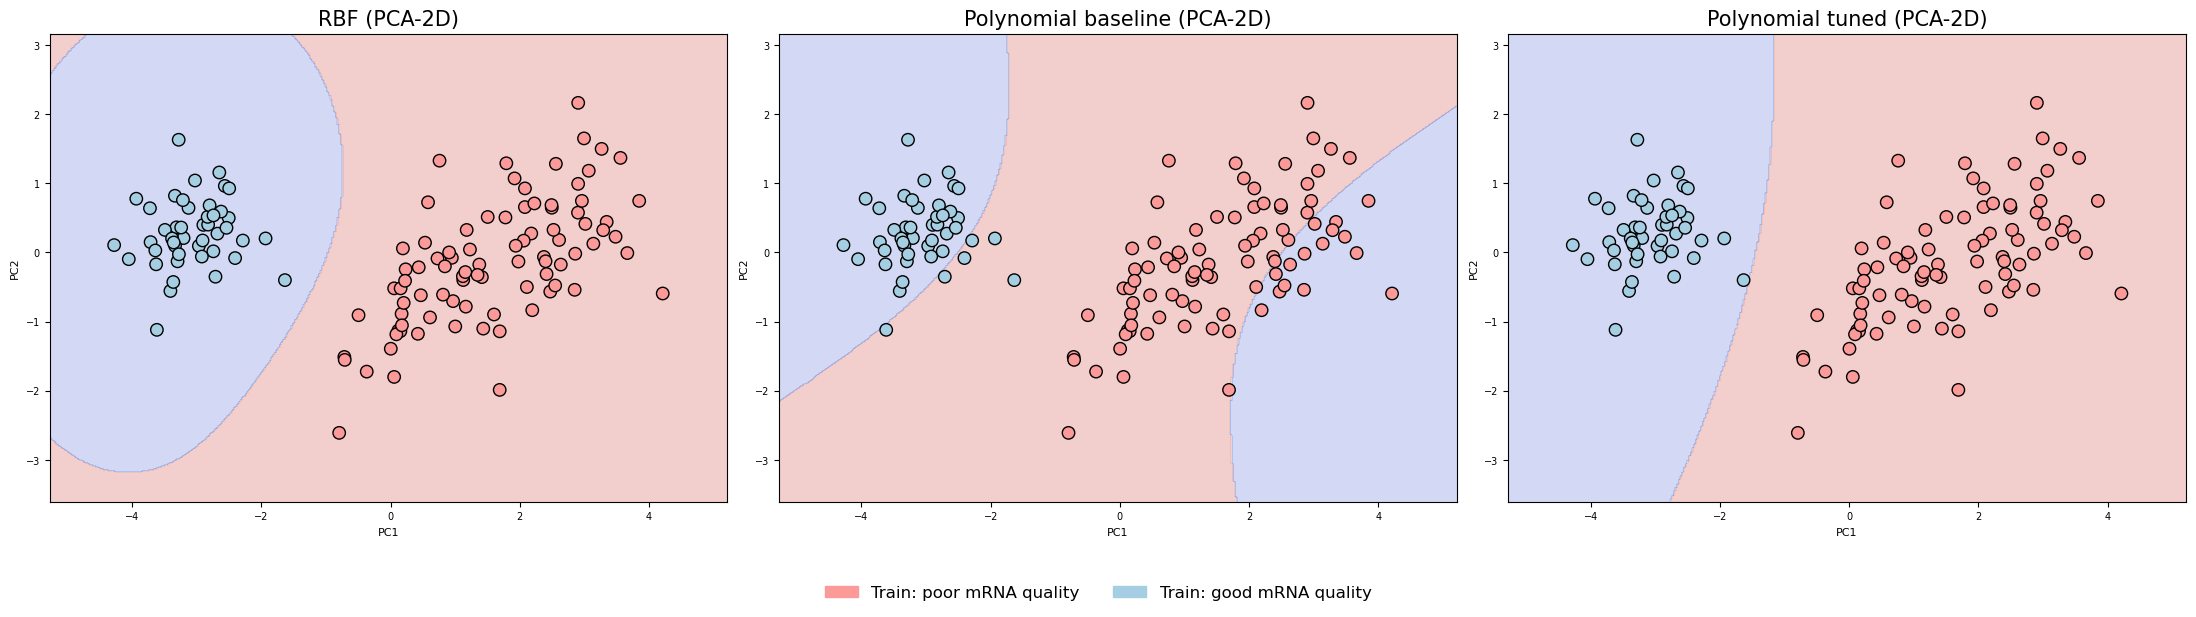

In [66]:
# =======================================================
# Decision boundaries trained directly on PCA-2D
# (Visualization only — does not affect the real model)
# =======================================================


# =======================================================
# 1) Generate meshgrid in PCA space
# =======================================================

x_min, x_max = X_tr_scaled_pca2[:, 0].min() - 1.0, X_tr_scaled_pca2[:, 0].max() + 1.0
y_min, y_max = X_tr_scaled_pca2[:, 1].min() - 1.0, X_tr_scaled_pca2[:, 1].max() + 1.0

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

grid = np.c_[xx.ravel(), yy.ravel()]


# =======================================================
# 2) Define VISUALIZATION MODELS (PCA-2D only)
# =======================================================

rbf_vis = SVC(kernel="rbf", class_weight="balanced")

poly_base_vis = SVC(
    kernel="poly",
    degree=2,
    class_weight="balanced"
)

poly_tuned_vis = SVC(
    kernel="poly",
    degree=2,
    C=best_params["C"],
    gamma=best_params["gamma"],
    coef0=best_params["coef0"],
    class_weight="balanced"
)


# =======================================================
# 3) Train visualization models on PCA-2D data
# =======================================================

rbf_vis.fit(X_tr_scaled_pca2, y_tr)
poly_base_vis.fit(X_tr_scaled_pca2, y_tr)
poly_tuned_vis.fit(X_tr_scaled_pca2, y_tr)


# =======================================================
# 4) Predict decision regions
# =======================================================

Z_rbf = rbf_vis.predict(grid).reshape(xx.shape)
Z_poly_base = poly_base_vis.predict(grid).reshape(xx.shape)
Z_poly_tuned = poly_tuned_vis.predict(grid).reshape(xx.shape)


# =======================================================
# 5) Plot panel (1 × 3)
# =======================================================

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

models = [
    ("RBF (PCA-2D)", Z_rbf),
    ("Polynomial baseline (PCA-2D)", Z_poly_base),
    ("Polynomial tuned (PCA-2D)", Z_poly_tuned),
]

cmap_train = ListedColormap([COLORS["train_0"], COLORS["train_1"]])

for ax, (title, Z) in zip(axes, models):

    ax.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.coolwarm_r)

    ax.scatter(
        X_tr_scaled_pca2[:, 0],
        X_tr_scaled_pca2[:, 1],
        c=y_tr,
        cmap=cmap_train,
        edgecolors='k',
        marker=MARKERS["train"],
        s=POINT_SIZES["train"]
    )

    ax.set_title(title, fontsize=15)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")


# =======================================================
# 6) Shared legend (TRAIN-80 only)
# =======================================================

legend_handles = [
    mpatches.Patch(color=COLORS["train_0"], label="Train: poor mRNA quality"),
    mpatches.Patch(color=COLORS["train_1"], label="Train: good mRNA quality"),
]

fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=2,
    fontsize=12,
    frameon=False,
    bbox_to_anchor=(0.5, -0.03),
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


Although the RBF boundary appears visually smooth in 2D PCA space, this projection does not reflect the full seven-dimensional feature space used for training. Kernel selection was based on donor-disjoint cross-validation performance and support vector fraction rather than on visualization. After tuning, the polynomial SVM was used for downstream thresholding and model application.

----
----

#### **Validation part**

#### Task 12: Threshold-free validation on the held-out set (VALID-20)

VALID-20 AUC (tuned POLY): 1.000


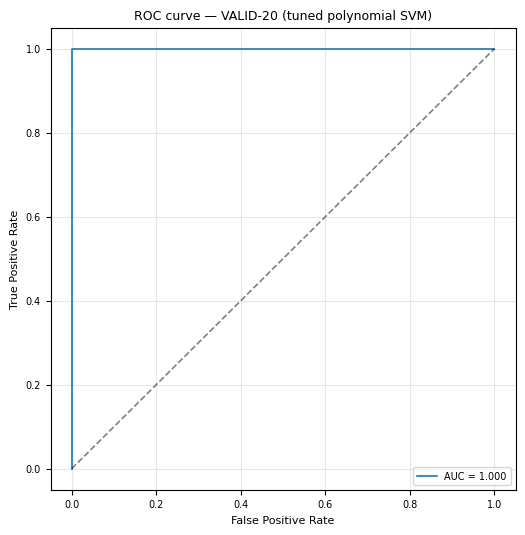

In [67]:
# =======================================================
# VALID-20 evaluation for tuned polynomial SVM
# =======================================================


# 1) Predict decision scores on VALID-20
y_val_scores = poly_tuned.decision_function(X_cal)

# Ensure y_cal is 0/1 integer array
y_val_true = y_cal.astype(int)

# 2) ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_scores, pos_label=1)
val_auc = auc(fpr, tpr)

print(f"VALID-20 AUC (tuned POLY): {val_auc:.3f}")

# 3) ROC plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {val_auc:.3f}")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve — VALID-20 (tuned polynomial SVM)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




----
----